In [1]:
import numpy as np, os
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings(action='ignore')

#한글설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정합니다.
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

In [9]:
fi = pd.read_csv('./data/df_all_best_type.csv')
COLS = list(pd.read_csv('/project/LSH/total_data_7727.csv')['ITEMID'].sort_values().unique())
model = tf.keras.models.load_model('/project/LSH/model/(LSTM_best_4068)seed42-05-0.5029.hdf5')

In [19]:
pre_list = fi[fi['Type']=='PRE'].feature.to_list()
lab_list = fi[fi['Type']=='LAB'].feature.to_list()
pro_list = fi[fi['Type']=='PRO'].feature.to_list()

def what_type(x):
    if x in pre_list:
        return 'PRE'
    elif x in lab_list:
        return 'LAB'
    elif x in pro_list:
        return 'PRO'
    else:
        return 'ERROR'

# FI에 ReLU 적용

In [20]:
#relu 함수 정의
def relu(x):
    return np.maximum(0, x)

In [21]:
tmp = fi.copy()
tmp['diff'] = tmp['diff'].apply(lambda x:relu(x))
relu_fi = tmp[['feature', 'diff']].sort_values('diff', ascending=False)

In [22]:
relu_fi

,feature,diff
0,409606211,0.059180
1,74606211,0.036668
2,67434504,0.032467
3,54817525,0.029130
4,10019055302,0.027498
...,...,...
3469,78005303,0.000000
3470,17317001801,0.000000
3471,597003212,0.000000
3472,51435,0.000000


# Prepare Data

In [23]:
import random    
seed_num = 42
random.seed(seed_num)
path = '/project/LSH/'
X = np.load(path + 'x_(7727,10,4068).npy')
y = np.load(path + 'y_(7727,1).npy')

idx = list(range(len(X)))
random.shuffle(idx)


i = round(X.shape[0]*0.8)
X_train, y_train = X[idx[:i],:,:], y[idx[:i]]
X_test, y_test = X[idx[i:],:,:], y[idx[i:]]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6182, 10, 4068), (6182,), (1545, 10, 4068), (1545,))

In [24]:
base_pred = np.mean(model.predict(X_test))
base_pred

0.63693285

# 0 to 1 - D-1~5

In [45]:
result = []
for i in tqdm(range(X_test.shape[2])):
    save_cols = X_test[:,:,i].copy()
    X_test[:,-5:,i] = 1
    # predict - base_pred
    pred = model.predict(X_test)
    value = np.mean(pred) - base_pred
    sign = 1 if value>=0 else -1
    result.append({'feature' : str(COLS[i]), 'diff' : value, 'sign' : sign})
    #값 복원
    X_test[:,:,i] = save_cols

  0%|          | 0/4068 [00:00<?, ?it/s]

In [46]:
near_df = pd.DataFrame(result)
near_df_ori = near_df.copy()
near_df.sort_values('diff', ascending=False)

,feature,diff,sign
2195,409606211,0.164619,1
1276,74606211,0.128329,1
1081,67434504,0.122029,1
2744,10019055302,0.111876,1
982,54817525,0.110186,1
...,...,...,...
37,50889,-0.088940,-1
162,51200,-0.089158,-1
3818,63323016101,-0.090798,-1
469,4003822,-0.095980,-1


## 최종 Score

In [48]:
near_result = near_df.feature.to_frame()
relu_fi_near = relu_fi.sort_values('feature').reset_index(drop=True)
relu_fi_near

,feature,diff
0,0,0.000000
1,50803,0.002118
2,50804,0.003495
3,50805,0.001575
4,50806,0.005405
...,...,...
4063,78112001103,0.002014
4064,79511050204,0.000000
4065,87701071218,0.013409
4066,87701083336,0.000000


In [51]:
near_result = near_df.feature.to_frame()
#정렬, reset index
relu_fi_near = relu_fi.sort_values('feature').reset_index(drop=True)
near_df = near_df.sort_values('feature').reset_index(drop=True)

near_result['score'] = relu_fi_near['diff'] * near_df['sign']
near_result = near_result.sort_values('score', ascending=False).reset_index(drop=True)

#save
near_result.to_csv('./data/method2_nearscore.csv', index=False)

near_result

,feature,score
0,54817525,0.029130
1,10019055302,0.027498
2,227194,0.025418
3,54858516,0.023033
4,45006701,0.020763
...,...,...
4063,4003822,-0.019987
4064,74706811,-0.021105
4065,67434504,-0.032467
4066,74606211,-0.036668


In [90]:
pd.read_csv('./data/method2_nearscore.csv')

,feature,score
0,54817525,0.029130
1,10019055302,0.027498
2,227194,0.025418
3,54858516,0.023033
4,45006701,0.020763
...,...,...
4063,4003822,-0.019987
4064,74706811,-0.021105
4065,67434504,-0.032467
4066,74606211,-0.036668


# 0 to 1 - D-6~10

In [53]:
result = []
for i in tqdm(range(X_test.shape[2])):
    save_cols = X_test[:,:,i].copy()
    X_test[:,:5,i] = 1
    # predict - base_pred
    pred = model.predict(X_test)
    value = np.mean(pred) - base_pred
    sign = 1 if value>=0 else -1
    result.append({'feature' : str(COLS[i]), 'diff' : value, 'sign' : sign})
    #값 복원
    X_test[:,:,i] = save_cols

  0%|          | 0/4068 [00:00<?, ?it/s]

In [54]:
away_df = pd.DataFrame(result)
away_df_ori = away_df.copy()
away_df.sort_values('diff', ascending=False)

,feature,diff,sign
2195,409606211,0.044158,1
1276,74606211,0.031872,1
982,54817525,0.031437,1
1081,67434504,0.030514,1
2744,10019055302,0.028482,1
...,...,...,...
1815,182138167,-0.022150,-1
162,51200,-0.022334,-1
37,50889,-0.023746,-1
469,4003822,-0.024094,-1


## 최종 Score

In [55]:
away_result = away_df.feature.to_frame()
#정렬, reset index
relu_fi_away = relu_fi.sort_values('feature').reset_index(drop=True)
away_df = away_df.sort_values('feature').reset_index(drop=True)

away_result['score'] = relu_fi_away['diff'] * away_df['sign']
away_result = away_result.sort_values('score', ascending=False).reset_index(drop=True)

#save
away_result.to_csv('./data/method2_awayscore.csv', index=False)

away_result

,feature,score
0,409606211,0.059180
1,67434504,0.032467
2,54817525,0.029130
3,10019055302,0.027498
4,227194,0.025418
...,...,...
4063,182138167,-0.017109
4064,58177025504,-0.017743
4065,228125,-0.018433
4066,4003822,-0.019987


# 역전되는 Feature 탐색
원거리(away_result['score']) - 근거리(near_result['score']) 

In [102]:
near_result = pd.read_csv('./data/method2_nearscore.csv')
away_result = pd.read_csv('./data/method2_awayscore.csv')

In [94]:
near_result = near_result.sort_values('feature').reset_index(drop=True)
away_result = away_result.sort_values('feature').reset_index(drop=True)

In [97]:
final_result = near_result.feature.to_frame()
final_result['diff_score'] = away_result['score'] - near_result['score']

final_result = final_result.sort_values('diff_score', ascending=False).reset_index(drop=True)
final_result['Type'] = final_result['feature'].apply(lambda x:what_type(int(x)))
final_result.to_csv('./data/method2_finalscore.csv', index=False)

In [98]:
final_result

,feature,diff_score,Type
0,409606211,0.118360,PRE
1,67434504,0.064935,PRE
2,74706811,0.042209,PRE
3,63323016501,0.036086,PRE
4,61703022521,0.027288,PRE
...,...,...,...
4063,50811,-0.009054,LAB
4064,173044202,-0.010061,PRE
4065,4026449,-0.010713,PRE
4066,68094020462,-0.016660,PRE


# Visualization

In [99]:
### 사망/퇴원 환자 df 분리

X = np.load('/project/LSH/x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')
# 컬럼이름 로드
COLS = list(pd.read_csv('/project/LSH/total_data_7727.csv')['ITEMID'].sort_values().unique())

#death_index
d_index = np.where(y==1)[0]
#survive_index (퇴원 환자)
s_index = np.where(y==0)[0]

#사망/퇴원 환자 분리
d_X = X[d_index]
s_X = X[s_index]

result = []
result_s = []
#day - 10일
for d in range(10):
    #4068 - ITEM
    for f in range(d_X.shape[-1]):
        d_sum = d_X[:,d,f].sum()/d_X.shape[0]
        s_sum = s_X[:,d,f].sum()/s_X.shape[0]
        result.append({'cols':COLS[f], 'day':10-d,'per':d_sum})
        result_s.append({'cols':COLS[f], 'day':10-d,'per':s_sum})
        
d_df = pd.DataFrame(result).sort_values(['cols','day']).reset_index(drop=True)
s_df = pd.DataFrame(result_s).sort_values(['cols','day']).reset_index(drop=True)
d_df.shape, s_df.shape

((40680, 3), (40680, 3))

In [100]:
def visualization(top10_list):
    plt.figure(figsize = (13,12), dpi=150)
    for i, f in enumerate(top10_list):
        plt.subplot(4,3,1+i)
        plt.title(f)
        ax = sns.lineplot(data = d_df[d_df['cols']==int(f)], x = 'day', y='per', label='사망')
        ax = sns.lineplot(data = s_df[s_df['cols']==int(f)], x = 'day', y='per', label='퇴원')
        ax.invert_xaxis()
        ax.legend(loc='upper left')
    plt.tight_layout()

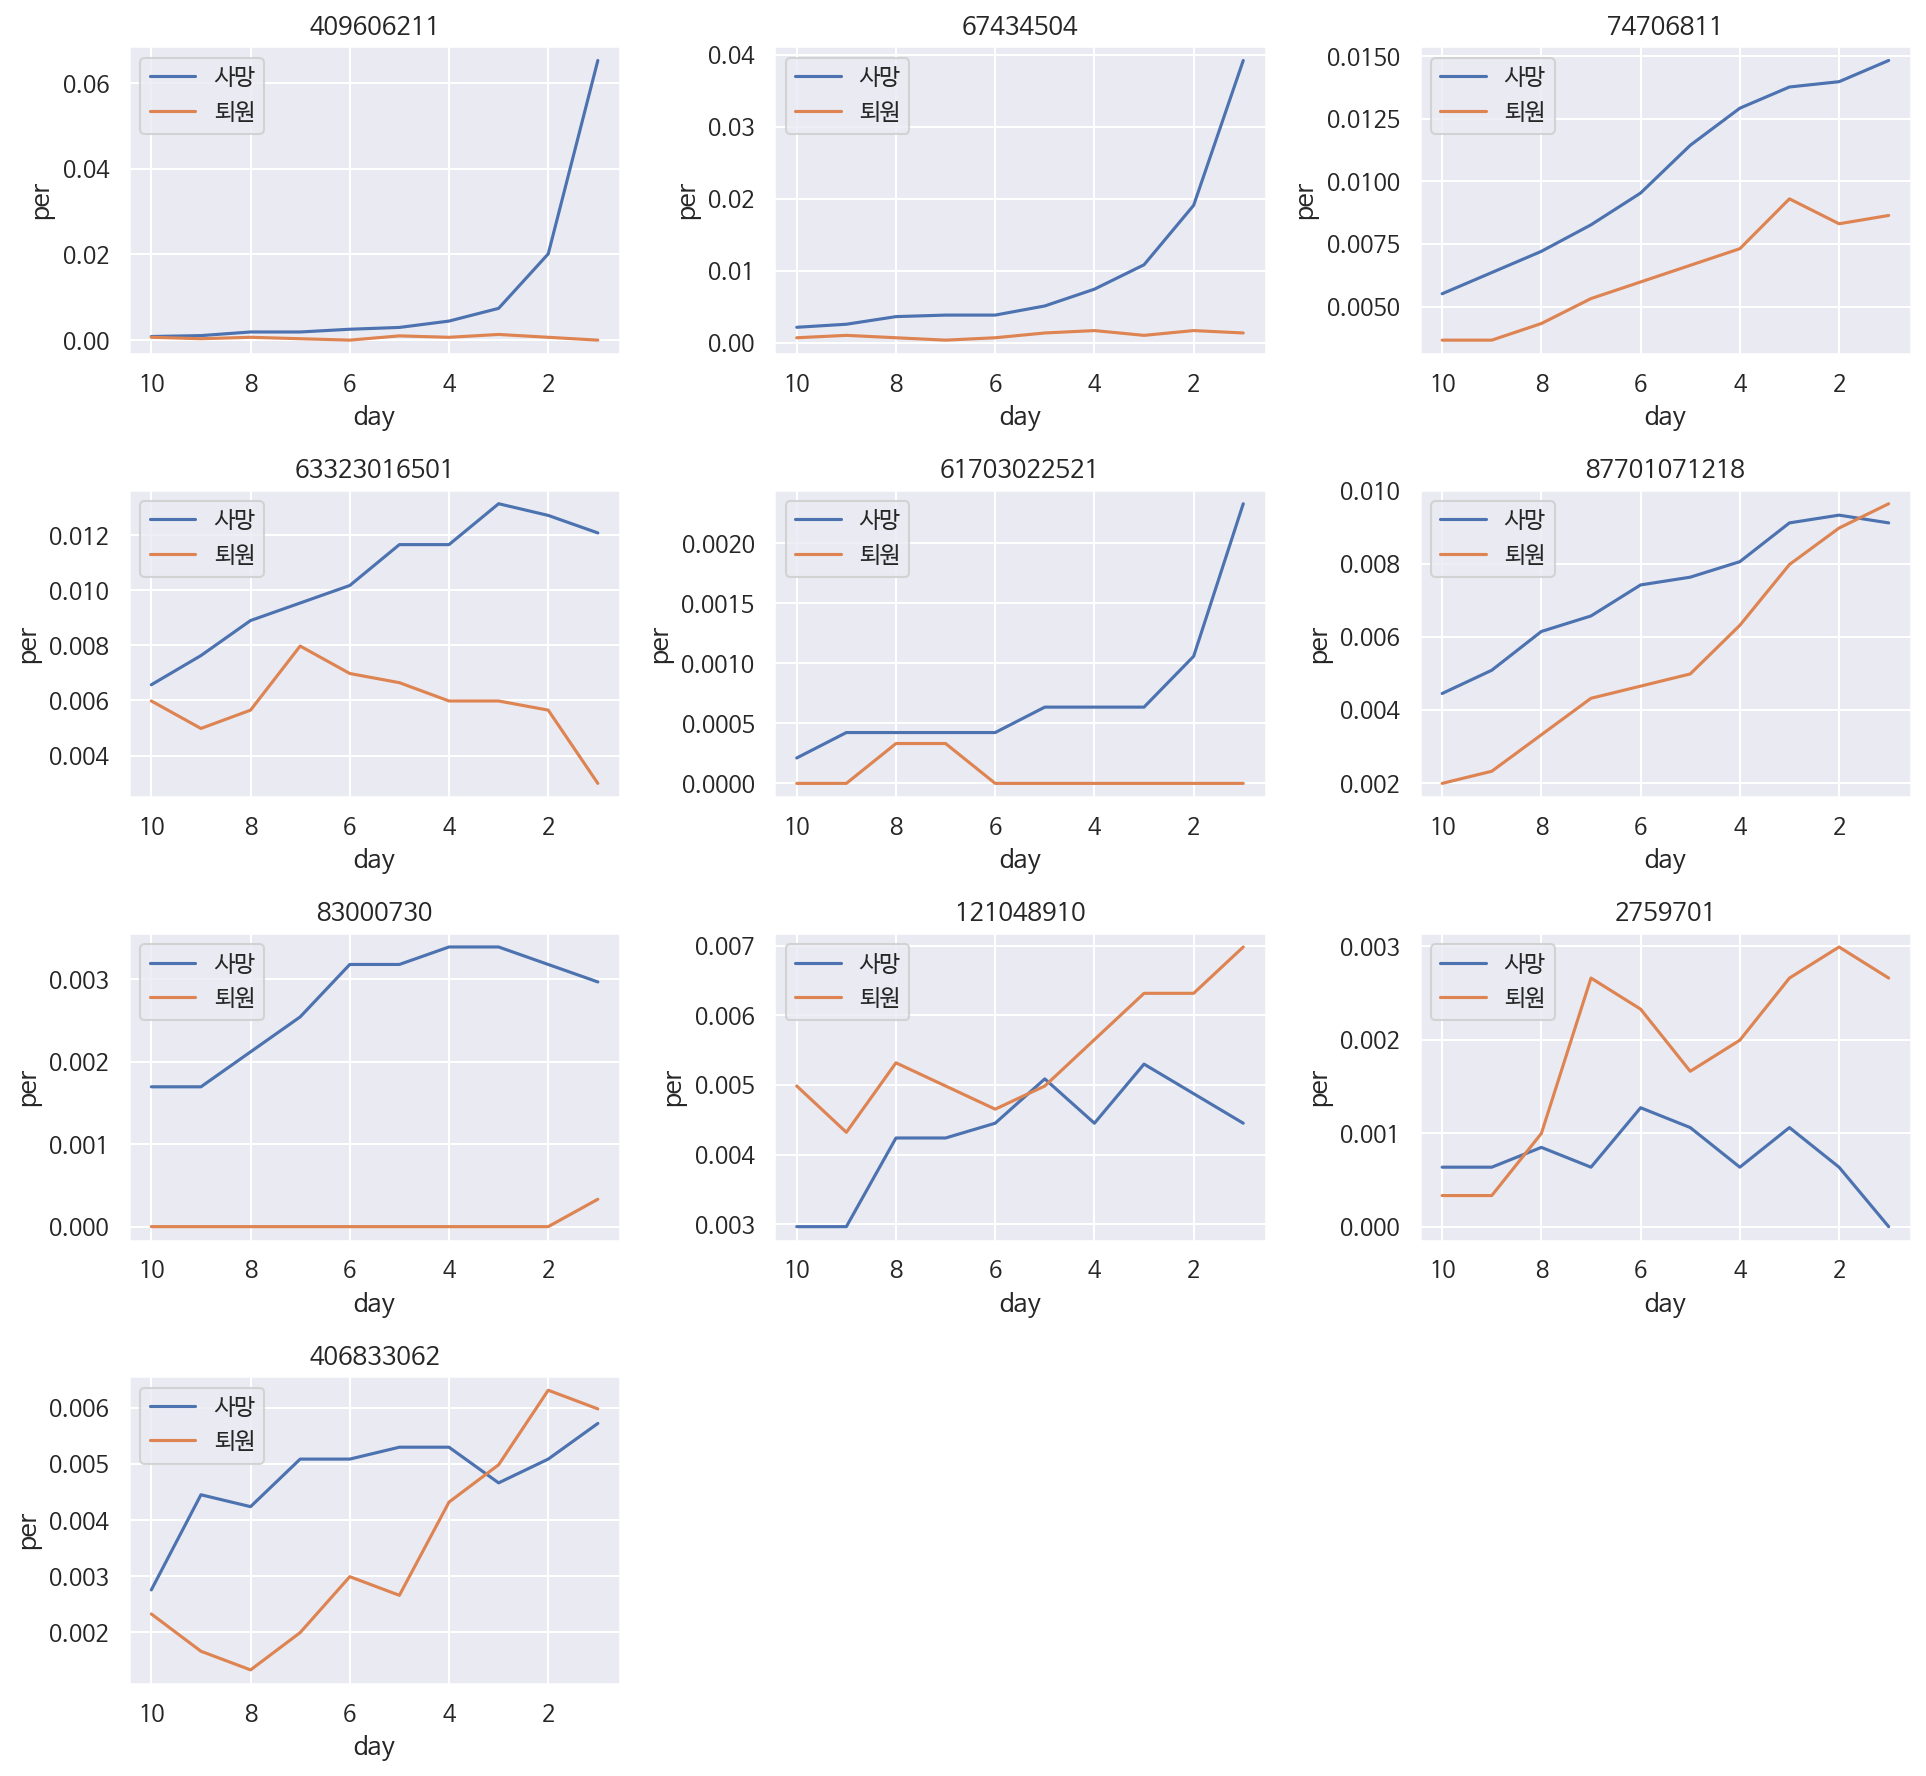

In [101]:
visualization(final_result.feature[:10])